In [53]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
import scipy.stats as sp
from scipy import stats
import matplotlib.pylab as plt
import numpy as np
from scipy.stats import mannwhitneyu

import matplotlib.pylab as plt
from matplotlib import pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import minimize
from scipy.spatial import distance

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
%matplotlib inline

In [54]:
#Cell fractions data derived from CIBERSORTx
result = pd.read_csv('CIBERSORTx_Job1_Results1.csv')
result.head()

,Mixture,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),...,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,P-value,Correlation,RMSE
0,TCGA-B2-4101-01A,0.030579,0.0,0.010362,0.270138,0.0,0.174607,0.004581,0.000000,0.012173,...,0.136117,0.048404,0.000000,0.093269,0.0,0.000000,0.000000,0.043,0.177885,1.018835
1,TCGA-BP-4342-01A,0.045675,0.0,0.000000,0.117228,0.0,0.326904,0.000000,0.018787,0.031528,...,0.218251,0.010841,0.000000,0.027348,0.0,0.000000,0.000000,0.032,0.195666,1.010012
2,TCGA-B0-4691-01A,0.025406,0.0,0.049794,0.400383,0.0,0.017437,0.000000,0.093648,0.051270,...,0.085589,0.014197,0.000000,0.015964,0.0,0.000000,0.000000,0.011,0.262677,1.004233
3,TCGA-BP-4167-01A,0.011994,0.0,0.002018,0.325929,0.0,0.124449,0.022024,0.036019,0.035104,...,0.237986,0.011931,0.000000,0.038493,0.0,0.000000,0.005619,0.001,0.383145,0.928987
4,TCGA-B8-4620-01A,0.031837,0.0,0.001936,0.024904,0.0,0.178736,0.029105,0.000000,0.013849,...,0.253609,0.000000,0.039219,0.011779,0.0,0.030303,0.125332,0.006,0.290582,0.965533


In [55]:
#Gene expression data
gene_exp=pd.read_csv('other_check.txt',sep='\t')
gene_exp=gene_exp.rename(columns={'Unnamed: 0':'Mixture'})
gene_exp.head()

,Mixture,RP11-368I23.2,RAB4B,C12orf5,RNF44,NUP210P2,DNAH3,RPL23A,EHD4-AS1,RPL7L1P12,...,LINC00272,TENM1,GABARAPL3,CYP4F2,RP11-486E2.1,AC010525.4,PPP6R1,RP4-569M23.2,BATF3,OR8D4
0,TCGA-B2-4101-01A,0.040527,0.145377,0.161284,0.317471,0.0,0.004431,0.557772,0.053541,0.000000,...,0.002736,0.129713,0.0,0.036292,0.000000,0.013123,0.285154,0.026969,0.074323,0.000000
1,TCGA-BP-4342-01A,0.008513,0.134508,0.127752,0.265787,0.0,0.002902,0.537691,0.025355,0.002135,...,0.010133,0.171494,0.0,0.061495,0.000000,0.054882,0.298477,0.024769,0.100181,0.000000
2,TCGA-B0-4691-01A,0.011578,0.167153,0.126276,0.265598,0.0,0.008699,0.520760,0.035718,0.002363,...,0.004604,0.155323,0.0,0.109413,0.009837,0.011205,0.263827,0.018424,0.119394,0.003854
3,TCGA-BP-4167-01A,0.002747,0.169332,0.140438,0.201546,0.0,0.000528,0.489484,0.022773,0.000000,...,0.005205,0.004056,0.0,0.015130,0.000000,0.023762,0.242827,0.013269,0.124644,0.000000
4,TCGA-B8-4620-01A,0.013596,0.090474,0.127375,0.225322,0.0,0.001030,0.551525,0.010590,0.004614,...,0.002299,0.069867,0.0,0.002701,0.000000,0.017857,0.214605,0.041011,0.082327,0.000000


In [5]:
# gene expression data for the genes that are being used in the model
gene_data=gene_exp
#I2, combination of interleukin-2 and interleukin-12A and interleukin-12B
gene_data['I2']=gene_exp['IL12A']+gene_exp['IL12B']+gene_exp['IL2']
#interleukin-10
gene_data['IL10']=gene_exp['IL10']
#Interleukin-6
gene_data['IL6']=gene_exp["IL6"]
#Interferon-gamma
gene_data['IFNg']=gene_exp['IFNG']
#High mobility group box-1 (HMGB1)
gene_data['HMGB1']=gene_exp["HMGB1"]
gene_data=gene_data.loc[:,['Mixture','I2','IL10','IL6','IFNg','HMGB1']]
gene_data=gene_data.set_index('Mixture')
gene_data=gene_data.drop(['Variance'])
gene_data.head()

,I2,IL10,IL6,IFNg,HMGB1
Mixture,,,,,
TCGA-B2-4101-01A,0.055885,0.039550,0.018208,0.049262,0.355369
TCGA-BP-4342-01A,0.039748,0.030334,0.104701,0.023168,0.334563
TCGA-B0-4691-01A,0.058813,0.032117,0.081602,0.066436,0.291993
TCGA-BP-4167-01A,0.047078,0.052157,0.067077,0.099112,0.295580
TCGA-B8-4620-01A,0.032142,0.096158,0.390538,0.002786,0.326734


In [9]:
#Filtering the CIBERSORTx results with less than 0.05 p-values
b= result[result['P-value'] <= 0.05]
b=b.drop(['P-value','Correlation','RMSE'],axis=1)
b=b.set_index('Mixture')
b

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
Mixture,,,,,,,,,,,,,,,,,,,,,
TCGA-B2-4101-01A,0.030579,0.0,0.010362,0.270138,0.0,0.174607,0.004581,0.000000,0.012173,0.013094,...,0.060812,0.000000,0.100849,0.136117,0.048404,0.000000,0.093269,0.000000,0.000000,0.000000
TCGA-BP-4342-01A,0.045675,0.0,0.000000,0.117228,0.0,0.326904,0.000000,0.018787,0.031528,0.000000,...,0.094396,0.000000,0.069828,0.218251,0.010841,0.000000,0.027348,0.000000,0.000000,0.000000
TCGA-B0-4691-01A,0.025406,0.0,0.049794,0.400383,0.0,0.017437,0.000000,0.093648,0.051270,0.042200,...,0.021150,0.000000,0.112791,0.085589,0.014197,0.000000,0.015964,0.000000,0.000000,0.000000
TCGA-BP-4167-01A,0.011994,0.0,0.002018,0.325929,0.0,0.124449,0.022024,0.036019,0.035104,0.049562,...,0.000039,0.000000,0.062485,0.237986,0.011931,0.000000,0.038493,0.000000,0.000000,0.005619
TCGA-B8-4620-01A,0.031837,0.0,0.001936,0.024904,0.0,0.178736,0.029105,0.000000,0.013849,0.022008,...,0.052250,0.101779,0.042627,0.253609,0.000000,0.039219,0.011779,0.000000,0.030303,0.125332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434-01A,0.001051,0.0,0.000889,0.281933,0.0,0.141469,0.021656,0.022217,0.021570,0.166096,...,0.000000,0.000000,0.112412,0.196779,0.000000,0.002814,0.023751,0.000000,0.000000,0.000000
TCGA-BP-4782-01A,0.003165,0.0,0.004004,0.269110,0.0,0.082839,0.014051,0.011918,0.034137,0.015067,...,0.023472,0.064993,0.087717,0.277501,0.009807,0.000000,0.061277,0.000000,0.000000,0.003103
TCGA-CJ-4895-01A,0.076067,0.0,0.010615,0.222270,0.0,0.061701,0.012613,0.044446,0.021471,0.022654,...,0.041843,0.068757,0.117338,0.242612,0.007724,0.000000,0.000000,0.008627,0.000091,0.008162


In [7]:
def model_cell(data):
    #input: cell fraction data
    #Output: New dataset with columns being the cells or combinations of cells in our model
    df=pd.DataFrame()
    df['Th']=data[['T cells CD4 memory activated','T cells follicular helper']].sum(axis=1)
    df['Tc']=data[['NK cells activated','T cells CD8']].sum(axis=1)
    df['Tr']=data[['T cells regulatory (Tregs)']]
    df['Tn']=data[['T cells CD4 naive', 'T cells CD4 memory resting','NK cells resting']].sum(axis=1)
    df['M']=data[['Macrophages M1', 'Macrophages M2']].sum(axis=1)
    df['Mn']=data[['Macrophages M0','Monocytes']].sum(axis=1)
    df['D']=data[['Dendritic cells activated']]
    df['Dn']=data[['Dendritic cells resting']]
    df['C']=""
    df['N']=""
    df["TIC"]=df.sum(axis=1)
    #Shortening the patient ids to match with clinical data
    #patient_id_rna2 = df.index
    #dic_patient_id2 = {id_:id_[:-4] for id_ in patient_id_rna2}
    #df=df.rename(dic_patient_id2, axis='index')
    #df= df[~df.index.duplicated(keep='first')]
    return df

In [10]:
#Cell variables that would be used in the model
cell_data=model_cell(b)
cell_data

,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC
Mixture,,,,,,,,,,,
TCGA-B2-4101,0.004581,0.290657,0.012173,0.199103,0.236965,0.060812,0.000000,0.048404,,,0.852696
TCGA-BP-4342,0.018787,0.123158,0.031528,0.360188,0.288079,0.094396,0.000000,0.010841,,,0.926977
TCGA-B0-4691,0.093648,0.470552,0.051270,0.017437,0.198381,0.021150,0.000000,0.014197,,,0.866636
TCGA-BP-4167,0.058043,0.362277,0.035104,0.124449,0.300471,0.000039,0.000000,0.011931,,,0.892314
TCGA-B8-4620,0.029105,0.024904,0.013849,0.219461,0.296236,0.154029,0.039219,0.000000,,,0.776804
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.043874,0.281933,0.021570,0.148832,0.309190,0.000000,0.002814,0.000000,,,0.808213
TCGA-BP-4782,0.025969,0.306949,0.034137,0.082839,0.365218,0.088465,0.000000,0.009807,,,0.913385
TCGA-CJ-4895,0.057059,0.255279,0.021471,0.061701,0.359949,0.110600,0.000000,0.007724,,,0.873784


In [11]:
#combine cells in the same group
T_CD4_arr = ['T cells CD4 naive', 'T cells CD4 memory resting', 'T cells CD4 memory activated','T cells follicular helper', 'T cells regulatory (Tregs)']
NK_arr = ['NK cells resting', 'NK cells activated']
M_arr = ['Macrophages M0', 'Macrophages M1', 'Macrophages M2']
Mast_arr=['Mast cells resting',
 'Mast cells activated']
DC_arr = ['Dendritic cells resting', 'Dendritic cells activated']

In [12]:
def add_columns(df):
    df['T cells CD4'] = df[T_CD4_arr].sum(axis=1)
    df['NK cells'] = df[NK_arr].sum(axis=1)
    df['Macrophages'] = df[M_arr].sum(axis=1)
    df['Mast cells']=df[Mast_arr].sum(axis=1)
    df['DC'] = df[DC_arr].sum(axis=1)
    return df

In [14]:
Ciber_result=add_columns(b)
#drop subcells that have been included in the model variables
Ciber_result=Ciber_result.drop(['Dendritic cells resting', 'Dendritic cells activated','Macrophages M0', 'Macrophages M1', 'Macrophages M2',
                          'T cells follicular helper',
 'T cells regulatory (Tregs)','NK cells resting', 'NK cells activated','T cells CD4 naive', 'T cells CD4 memory resting', 'T cells CD4 memory activated', 
         'Mast cells resting',
 'Mast cells activated','B cells naive', 'B cells memory'],axis=1)
Ciber_result.head()

,Plasma cells,T cells CD8,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,T cells CD4,NK cells,Macrophages,Mast cells,DC
Mixture,,,,,,,,,,,
TCGA-B2-4101-01A,0.010362,0.270138,0.013094,0.060812,0.000000,0.000000,0.191361,0.045015,0.236965,0.093269,0.048404
TCGA-BP-4342-01A,0.000000,0.117228,0.000000,0.094396,0.000000,0.000000,0.377219,0.039214,0.288079,0.027348,0.010841
TCGA-B0-4691-01A,0.049794,0.400383,0.042200,0.021150,0.000000,0.000000,0.162356,0.070170,0.198381,0.015964,0.014197
TCGA-BP-4167-01A,0.002018,0.325929,0.049562,0.000039,0.000000,0.005619,0.217596,0.036349,0.300471,0.038493,0.011931
TCGA-B8-4620-01A,0.001936,0.024904,0.022008,0.052250,0.030303,0.125332,0.221690,0.040725,0.398016,0.011779,0.039219


In [15]:
Ciber_result=Ciber_result.rename({'T cells CD8':'CD8 T cells','T cells CD4':'CD4 T cells'},axis='columns')
Ciber_result

In [27]:
#gene mixture data with hugo symbol
mixture = pd.read_csv('TCGA-KIRC.htseq_fpkm_hugo.tsv',  sep='\t')
mixture=mixture.rename(columns={'Ensembl_ID':'Hugo_Symbol'})
mixture[['Hugo_Symbol']] = mixture[['Hugo_Symbol']].astype(str)
mixture.shape

(53642, 608)

In [30]:
#Remove it from the final code
#RGS5=RGS5.drop(39215, axis=0)
mixture=mixture.set_index(['Hugo_Symbol'])
mixture=mixture.T
mixture.head()

Hugo_Symbol,RP11-368I23.2,RAB4B,C12orf5,RNF44,NUP210P2,DNAH3,RPL23A,EHD4-AS1,RPL7L1P12,Y_RNA,...,LINC00272,TENM1,GABARAPL3,CYP4F2,RP11-486E2.1,AC010525.4,PPP6R1,RP4-569M23.2,BATF3,OR8D4
TCGA-B2-4101-01A,0.536271,1.923713,2.134200,4.200956,0.0,0.058632,7.380768,0.708489,0.000000,0.000000,...,0.036201,1.716444,0.0,0.480241,0.00000,0.173656,3.773318,0.356871,0.983490,0.000000
TCGA-BP-4342-01A,0.112216,1.773085,1.684026,3.503601,0.0,0.038257,7.087823,0.334233,0.028137,0.000000,...,0.133577,2.260630,0.0,0.810629,0.00000,0.723458,3.934508,0.326509,1.320583,0.000000
TCGA-B0-4691-01A,0.167743,2.421759,1.829515,3.848051,0.0,0.126032,7.544912,0.517496,0.034240,0.000000,...,0.066703,2.250367,0.0,1.585203,0.14252,0.162346,3.822395,0.266937,1.729807,0.055839
TCGA-BP-4167-01A,0.040737,2.510947,2.082486,2.988625,0.0,0.007822,7.258326,0.337690,0.000000,0.000000,...,0.077183,0.060147,0.0,0.224363,0.00000,0.352362,3.600758,0.196763,1.848291,0.000000
TCGA-B8-4620-01A,0.190762,1.269437,1.787195,3.161479,0.0,0.014447,7.738407,0.148589,0.064737,0.219096,...,0.032250,0.980305,0.0,0.037903,0.00000,0.250555,3.011113,0.575417,1.155126,0.000000


In [31]:
clinical_data = pd.read_csv('clinical_data_NEW.csv')
clinical_data=clinical_data.set_index(['PATIENT_ID'])
#clinical_data=clinical_data.drop(['RGS5','RGS5 level'],axis=1)
clinical_data.head()

,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,DAYS_TO_BIRTH,RACE,...,SERUM_LATERALITY,SERUM_OS,TUMOR_SERUM,OS_WBC,TUMOR_WBC,sex_and_os_status,Later os_status,TUMOR_LATERALITY,TUMOR_SEX,SEX_LATERALITY
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-3Z-A93Z,2B1DEA0A-6D55-4FDD-9C1C-0D9FBE03BD78,11/11/14,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,Male,-25205,BLACK OR AFRICAN AMERICAN,...,"Normal, Right","Living, Normal","Tumor Free, Normal","Living, Normal","Tumor Free, Normal","Male, Living","Right, Living","Tumor Free, Right","Tumor Free, Male","Male, Right"
TCGA-6D-AA2E,D3B47E53-6F40-4FC8-B5A4-CBE548A770A9,3/17/14,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,Female,-25043,BLACK OR AFRICAN AMERICAN,...,NaN,NaN,NaN,NaN,NaN,"Female, Living","Right, Living","Tumor Free, Right","Tumor Free, Female","Female, Right"
TCGA-A3-3306,9fb55e0b-43d8-40a3-8ef2-d198e6290551,8/23/10,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,-24569,WHITE,...,NaN,NaN,NaN,NaN,NaN,"Male, Living","Left, Living",NaN,NaN,"Male, Left"
TCGA-A3-3307,7ac1d6c6-9ade-49af-8794-10b5b96b2b05,4/13/10,Kidney Clear Cell Renal Carcinoma,G3,Right,NO,YES,Male,-24315,[Not Available],...,NaN,NaN,NaN,NaN,NaN,"Male, Living","Right, Living","With Tumor, Right","With Tumor, Male","Male, Right"
TCGA-A3-3308,3cbca837-f5a7-4a87-8f02-c59eac232d5a,4/12/10,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Female,-28287,WHITE,...,"Normal, Right","Living, Normal","Tumor Free, Normal","Living, Normal","Tumor Free, Normal","Female, Living","Right, Living","Tumor Free, Right","Tumor Free, Female","Female, Right"


In [33]:
#patient_id_rna2 = mixture.index
#dic_patient_id2 = {id_:id_[:-4] for id_ in patient_id_rna2}

#mixture=mixture.rename(dic_patient_id2, axis='index')

#mixture= mixture[~mixture.index.duplicated(keep='first')]
#mixture.head()

Hugo_Symbol,RP11-368I23.2,RAB4B,C12orf5,RNF44,NUP210P2,DNAH3,RPL23A,EHD4-AS1,RPL7L1P12,Y_RNA,...,LINC00272,TENM1,GABARAPL3,CYP4F2,RP11-486E2.1,AC010525.4,PPP6R1,RP4-569M23.2,BATF3,OR8D4
TCGA-B2-4101,0.536271,1.923713,2.134200,4.200956,0.0,0.058632,7.380768,0.708489,0.000000,0.000000,...,0.036201,1.716444,0.0,0.480241,0.00000,0.173656,3.773318,0.356871,0.983490,0.000000
TCGA-BP-4342,0.112216,1.773085,1.684026,3.503601,0.0,0.038257,7.087823,0.334233,0.028137,0.000000,...,0.133577,2.260630,0.0,0.810629,0.00000,0.723458,3.934508,0.326509,1.320583,0.000000
TCGA-B0-4691,0.167743,2.421759,1.829515,3.848051,0.0,0.126032,7.544912,0.517496,0.034240,0.000000,...,0.066703,2.250367,0.0,1.585203,0.14252,0.162346,3.822395,0.266937,1.729807,0.055839
TCGA-BP-4167,0.040737,2.510947,2.082486,2.988625,0.0,0.007822,7.258326,0.337690,0.000000,0.000000,...,0.077183,0.060147,0.0,0.224363,0.00000,0.352362,3.600758,0.196763,1.848291,0.000000
TCGA-B8-4620,0.190762,1.269437,1.787195,3.161479,0.0,0.014447,7.738407,0.148589,0.064737,0.219096,...,0.032250,0.980305,0.0,0.037903,0.00000,0.250555,3.011113,0.575417,1.155126,0.000000


In [34]:
patients_cBio = clinical_data.index.values
mixture_patients = mixture.index.values

patients_ = [patient for patient in patients_cBio if patient not in mixture_patients]
patients_2= [patient for patient in mixture_patients if patient not in patients_cBio]
clinical_data = clinical_data.drop(index= patients_)


In [35]:
clinical = pd.concat([clinical_data, mixture], axis=1, sort=False)
clinical.head()

,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,DAYS_TO_BIRTH,RACE,...,LINC00272,TENM1,GABARAPL3,CYP4F2,RP11-486E2.1,AC010525.4,PPP6R1,RP4-569M23.2,BATF3,OR8D4
TCGA-3Z-A93Z,2B1DEA0A-6D55-4FDD-9C1C-0D9FBE03BD78,11/11/14,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,Male,-25205,BLACK OR AFRICAN AMERICAN,...,0.000000,1.145078,0.0,0.013550,0.0,0.093870,3.487291,0.156687,2.013652,0.000000
TCGA-6D-AA2E,D3B47E53-6F40-4FC8-B5A4-CBE548A770A9,3/17/14,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,Female,-25043,BLACK OR AFRICAN AMERICAN,...,0.000000,1.026720,0.0,0.032481,0.0,0.216888,3.531471,0.195356,0.551751,0.000000
TCGA-A3-3306,9fb55e0b-43d8-40a3-8ef2-d198e6290551,8/23/10,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,-24569,WHITE,...,0.089708,1.618591,0.0,0.000000,0.0,0.075637,3.450284,0.451445,2.528182,0.000000
TCGA-A3-3307,7ac1d6c6-9ade-49af-8794-10b5b96b2b05,4/13/10,Kidney Clear Cell Renal Carcinoma,G3,Right,NO,YES,Male,-24315,[Not Available],...,0.042950,1.755118,0.0,0.040496,0.0,0.071359,3.499879,0.119725,1.711437,0.000000
TCGA-A3-3308,3cbca837-f5a7-4a87-8f02-c59eac232d5a,4/12/10,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Female,-28287,WHITE,...,0.077249,1.773022,0.0,0.027765,0.0,0.501146,3.845074,0.182695,0.976504,0.021892


In [36]:
#patient_id_rna2 = Ciber_result.index
#dic_patient_id2 = {id_:id_[:-4] for id_ in patient_id_rna2}

#Ciber_result=Ciber_result.rename(dic_patient_id2, axis='index')

#Ciber_result= Ciber_result[~Ciber_result.index.duplicated(keep='first')]

In [38]:
Ciber_result

,Plasma cells,CD8 T cells,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,CD4 T cells,NK cells,Macrophages,Mast cells,DC
Mixture,,,,,,,,,,,
TCGA-B2-4101,0.010362,0.270138,0.013094,0.060812,0.000000,0.000000,0.191361,0.045015,0.236965,0.093269,0.048404
TCGA-BP-4342,0.000000,0.117228,0.000000,0.094396,0.000000,0.000000,0.377219,0.039214,0.288079,0.027348,0.010841
TCGA-B0-4691,0.049794,0.400383,0.042200,0.021150,0.000000,0.000000,0.162356,0.070170,0.198381,0.015964,0.014197
TCGA-BP-4167,0.002018,0.325929,0.049562,0.000039,0.000000,0.005619,0.217596,0.036349,0.300471,0.038493,0.011931
TCGA-B8-4620,0.001936,0.024904,0.022008,0.052250,0.030303,0.125332,0.221690,0.040725,0.398016,0.011779,0.039219
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.000889,0.281933,0.166096,0.000000,0.000000,0.000000,0.206913,0.007363,0.309190,0.023751,0.002814
TCGA-BP-4782,0.004004,0.269110,0.015067,0.023472,0.000000,0.003103,0.142946,0.037839,0.430211,0.061277,0.009807
TCGA-CJ-4895,0.010615,0.222270,0.022654,0.041843,0.000091,0.008162,0.140231,0.033009,0.428706,0.008627,0.007724


In [39]:
patients_cBio = clinical.index.values
mixture_patients = Ciber_result.index.values

patients_ = [patient for patient in patients_cBio if patient not in mixture_patients]
#patients_2= [patient for patient in mixture_patients if patient not in patients_cBio]



clinical = clinical.drop(index= patients_)
clinical = pd.concat([clinical, Ciber_result], axis=1, sort=False)
clinical.head()

,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,DAYS_TO_BIRTH,RACE,...,CD8 T cells,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,CD4 T cells,NK cells,Macrophages,Mast cells,DC
TCGA-6D-AA2E,D3B47E53-6F40-4FC8-B5A4-CBE548A770A9,3/17/14,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,Female,-25043,BLACK OR AFRICAN AMERICAN,...,0.165446,0.000000,0.047463,0.0,0.000000,0.175845,0.033703,0.197386,0.035076,0.005309
TCGA-A3-3307,7ac1d6c6-9ade-49af-8794-10b5b96b2b05,4/13/10,Kidney Clear Cell Renal Carcinoma,G3,Right,NO,YES,Male,-24315,[Not Available],...,0.310920,0.010723,0.148006,0.0,0.016171,0.088869,0.000000,0.387997,0.032609,0.001176
TCGA-A3-3308,3cbca837-f5a7-4a87-8f02-c59eac232d5a,4/12/10,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Female,-28287,WHITE,...,0.108193,0.000000,0.085013,0.0,0.000000,0.161532,0.035343,0.517407,0.060260,0.000000
TCGA-A3-3311,0c139772-e303-45d1-b0c7-438fa1db105e,4/20/10,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Male,-21183,[Not Available],...,0.169854,0.023851,0.149907,0.0,0.004012,0.184432,0.002508,0.312352,0.038168,0.000838
TCGA-A3-3316,12c4c4f1-5880-4bf9-9945-80bf45415de6,4/14/10,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,-20931,WHITE,...,0.048352,0.001664,0.124343,0.0,0.012655,0.156143,0.017623,0.559328,0.033108,0.000000


## Clustering

In [40]:
Ciber_result.head()

,Plasma cells,CD8 T cells,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,CD4 T cells,NK cells,Macrophages,Mast cells,DC
Mixture,,,,,,,,,,,
TCGA-B2-4101,0.010362,0.270138,0.013094,0.060812,0.000000,0.000000,0.191361,0.045015,0.236965,0.093269,0.048404
TCGA-BP-4342,0.000000,0.117228,0.000000,0.094396,0.000000,0.000000,0.377219,0.039214,0.288079,0.027348,0.010841
TCGA-B0-4691,0.049794,0.400383,0.042200,0.021150,0.000000,0.000000,0.162356,0.070170,0.198381,0.015964,0.014197
TCGA-BP-4167,0.002018,0.325929,0.049562,0.000039,0.000000,0.005619,0.217596,0.036349,0.300471,0.038493,0.011931
TCGA-B8-4620,0.001936,0.024904,0.022008,0.052250,0.030303,0.125332,0.221690,0.040725,0.398016,0.011779,0.039219


In [41]:
cell_proportions=Ciber_result
cell_proportions.head()

,Plasma cells,CD8 T cells,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,CD4 T cells,NK cells,Macrophages,Mast cells,DC
Mixture,,,,,,,,,,,
TCGA-B2-4101,0.010362,0.270138,0.013094,0.060812,0.000000,0.000000,0.191361,0.045015,0.236965,0.093269,0.048404
TCGA-BP-4342,0.000000,0.117228,0.000000,0.094396,0.000000,0.000000,0.377219,0.039214,0.288079,0.027348,0.010841
TCGA-B0-4691,0.049794,0.400383,0.042200,0.021150,0.000000,0.000000,0.162356,0.070170,0.198381,0.015964,0.014197
TCGA-BP-4167,0.002018,0.325929,0.049562,0.000039,0.000000,0.005619,0.217596,0.036349,0.300471,0.038493,0.011931
TCGA-B8-4620,0.001936,0.024904,0.022008,0.052250,0.030303,0.125332,0.221690,0.040725,0.398016,0.011779,0.039219


In [42]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,12) 
  
for k in K: 
    #k-means clustering on patients immune infiltration
    kmeanModel = KMeans(n_clusters=k).fit(cell_proportions) 
    kmeanModel.fit(cell_proportions)     
      
    distortions.append(sum(np.min(cdist(cell_proportions, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / cell_proportions.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(cell_proportions, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / cell_proportions.shape[0] 
          
    mapping2[k] = kmeanModel.inertia_ 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_mea

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:445: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://nu

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

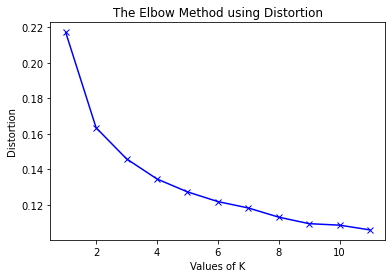

In [43]:
plt.figure
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [44]:
kmeans = KMeans(n_clusters=4)

y = kmeans.fit_predict(cell_proportions)

cell_proportions['4_clusters'] = y

cell_proportions.head()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairw

,Plasma cells,CD8 T cells,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,CD4 T cells,NK cells,Macrophages,Mast cells,DC,4_clusters
Mixture,,,,,,,,,,,,
TCGA-B2-4101,0.010362,0.270138,0.013094,0.060812,0.000000,0.000000,0.191361,0.045015,0.236965,0.093269,0.048404,0
TCGA-BP-4342,0.000000,0.117228,0.000000,0.094396,0.000000,0.000000,0.377219,0.039214,0.288079,0.027348,0.010841,3
TCGA-B0-4691,0.049794,0.400383,0.042200,0.021150,0.000000,0.000000,0.162356,0.070170,0.198381,0.015964,0.014197,2
TCGA-BP-4167,0.002018,0.325929,0.049562,0.000039,0.000000,0.005619,0.217596,0.036349,0.300471,0.038493,0.011931,0
TCGA-B8-4620,0.001936,0.024904,0.022008,0.052250,0.030303,0.125332,0.221690,0.040725,0.398016,0.011779,0.039219,1


In [32]:
#cell_proportions=cell_proportions.rename(columns={"4_clusters": "Clusters"})

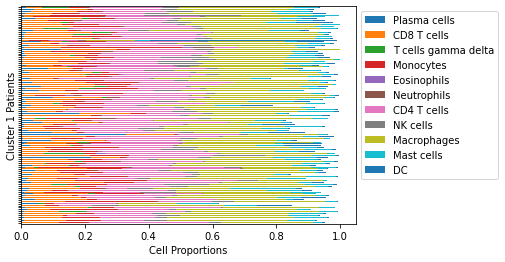

In [34]:
#Cluster 1 cell frequency bar graph
c1=cell_proportions[cell_proportions['4_clusters']==0]
c1=c1.iloc[:,:11]
c1.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1.0))
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
plt.ylabel('Cluster 1 Patients')
plt.xlabel('Cell Proportions')
plt.show()

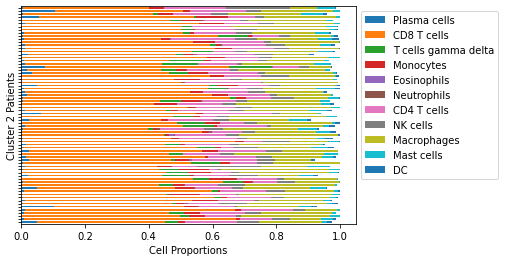

In [35]:
#Cluster 2 cell frequency bar graph
c2=cell_proportions[cell_proportions['4_clusters']==1]
c2=c2.iloc[:,:11]
c2.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1.0))
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
plt.ylabel('Cluster 2 Patients')
plt.xlabel('Cell Proportions')
plt.show()

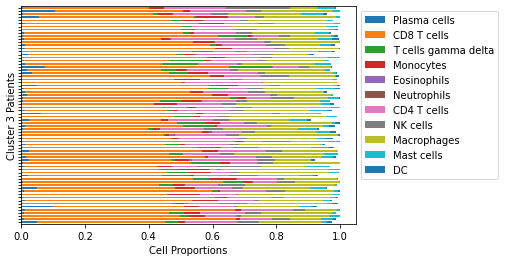

In [36]:
#Cluster 3 cell frequency bar graph
c3=cell_proportions[cell_proportions['4_clusters']==2]
c3=c2.iloc[:,:11]
c3.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1.0))
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
plt.ylabel('Cluster 3 Patients')
plt.xlabel('Cell Proportions')
plt.show()

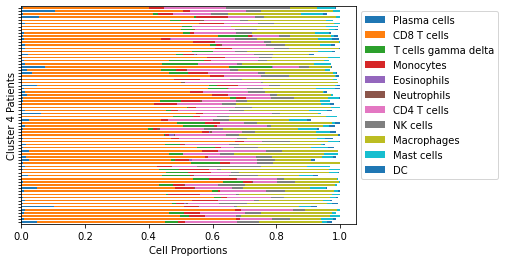

In [258]:
#Cluster 4 cell frequency bar graph
c4=cell_proportions[cell_proportions['4_clusters']==3]
c4=c2.iloc[:,:11]
c4.plot.barh(stacked=True)
plt.legend(bbox_to_anchor=(1.0, 1.0))
frame1 = plt.gca()
for xlabel_i in frame1.axes.get_yticklabels():
    xlabel_i.set_fontsize(0.0)
    xlabel_i.set_visible(False)
plt.ylabel('Cluster 4 Patients')
plt.xlabel('Cell Proportions')
plt.show()

In [46]:
#cell_proportions['4_clusters'] = cell_proportions['4_clusters'].map({0:'cluster_1',1:'cluster_2',2:'cluster_3',3:'cluster_4'})

a=cell_proportions
a

,Plasma cells,CD8 T cells,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,CD4 T cells,NK cells,Macrophages,Mast cells,DC,4_clusters
Mixture,,,,,,,,,,,,
TCGA-B2-4101,0.010362,0.270138,0.013094,0.060812,0.000000,0.000000,0.191361,0.045015,0.236965,0.093269,0.048404,0
TCGA-BP-4342,0.000000,0.117228,0.000000,0.094396,0.000000,0.000000,0.377219,0.039214,0.288079,0.027348,0.010841,3
TCGA-B0-4691,0.049794,0.400383,0.042200,0.021150,0.000000,0.000000,0.162356,0.070170,0.198381,0.015964,0.014197,2
TCGA-BP-4167,0.002018,0.325929,0.049562,0.000039,0.000000,0.005619,0.217596,0.036349,0.300471,0.038493,0.011931,0
TCGA-B8-4620,0.001936,0.024904,0.022008,0.052250,0.030303,0.125332,0.221690,0.040725,0.398016,0.011779,0.039219,1
...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.000889,0.281933,0.166096,0.000000,0.000000,0.000000,0.206913,0.007363,0.309190,0.023751,0.002814,0
TCGA-BP-4782,0.004004,0.269110,0.015067,0.023472,0.000000,0.003103,0.142946,0.037839,0.430211,0.061277,0.009807,0
TCGA-CJ-4895,0.010615,0.222270,0.022654,0.041843,0.000091,0.008162,0.140231,0.033009,0.428706,0.008627,0.007724,0


In [47]:
clinical = pd.concat([clinical, a], axis=1, sort=False)
clinical

,OTHER_PATIENT_ID,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,GRADE,LATERALITY,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,DAYS_TO_BIRTH,RACE,...,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,CD4 T cells,NK cells,Macrophages,Mast cells,DC,4_clusters
TCGA-6D-AA2E,D3B47E53-6F40-4FC8-B5A4-CBE548A770A9,3/17/14,Kidney Clear Cell Renal Carcinoma,G2,Right,YES,NO,Female,-25043,BLACK OR AFRICAN AMERICAN,...,0.000000,0.047463,0.0,0.000000,0.175845,0.033703,0.197386,0.035076,0.005309,3
TCGA-A3-3307,7ac1d6c6-9ade-49af-8794-10b5b96b2b05,4/13/10,Kidney Clear Cell Renal Carcinoma,G3,Right,NO,YES,Male,-24315,[Not Available],...,0.010723,0.148006,0.0,0.016171,0.088869,0.000000,0.387997,0.032609,0.001176,0
TCGA-A3-3308,3cbca837-f5a7-4a87-8f02-c59eac232d5a,4/12/10,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Female,-28287,WHITE,...,0.000000,0.085013,0.0,0.000000,0.161532,0.035343,0.517407,0.060260,0.000000,1
TCGA-A3-3311,0c139772-e303-45d1-b0c7-438fa1db105e,4/20/10,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Male,-21183,[Not Available],...,0.023851,0.149907,0.0,0.004012,0.184432,0.002508,0.312352,0.038168,0.000838,3
TCGA-A3-3316,12c4c4f1-5880-4bf9-9945-80bf45415de6,4/14/10,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,-20931,WHITE,...,0.001664,0.124343,0.0,0.012655,0.156143,0.017623,0.559328,0.033108,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-G6-A8L6,28011111-4A01-4CDC-8D6B-7223FB2C501B,4/3/14,Kidney Clear Cell Renal Carcinoma,G3,Left,NO,YES,Male,-20306,BLACK OR AFRICAN AMERICAN,...,0.000000,0.225515,0.0,0.000000,0.282635,0.064192,0.203699,0.012928,0.000000,3
TCGA-GK-A6C7,0DF9EC46-D600-4845-9D00-2DC2732C68D1,11/26/13,Kidney Clear Cell Renal Carcinoma,[Not Available],Right,YES,NO,Female,-28107,BLACK OR AFRICAN AMERICAN,...,0.000000,0.091200,0.0,0.000000,0.149444,0.149984,0.244331,0.097449,0.037781,3
TCGA-MM-A563,FE1F95A3-A6C2-4A39-8586-F8A70E975DD4,6/14/13,Kidney Clear Cell Renal Carcinoma,G2,Left,NO,YES,Male,-15037,BLACK OR AFRICAN AMERICAN,...,0.040108,0.063753,0.0,0.000000,0.183812,0.017904,0.342389,0.053661,0.031016,3
TCGA-MM-A564,620BAEFA-DB8F-4AF9-9101-4B9B252FA73E,6/14/13,Kidney Clear Cell Renal Carcinoma,G2,Right,NO,YES,Male,-24916,BLACK OR AFRICAN AMERICAN,...,0.000000,0.176563,0.0,0.000000,0.118008,0.305846,0.223362,0.082929,0.000000,3


In [48]:
clinical=clinical.rename(columns={"4_clusters":"Clusters"})
clinical['Clusters']=clinical['Clusters'].map({0:'Cluster 1',1:'Cluster 2',2:'Cluster 3',3:'Cluster 4'})

In [49]:
#Shortening the patient ids on gene_data
patient_id_rna2 = gene_data.index
dic_patient_id2 = {id_:id_[:-4] for id_ in patient_id_rna2}

gene_data=gene_data.rename(dic_patient_id2, axis='index')

gene_data= gene_data[~gene_data.index.duplicated(keep='first')]
gene_data.head()

,I2,IL10,IL6,IFNg,HMGB1
Mixture,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734


In [50]:
#Combined data of cells and genes
cell_gene_comb=pd.concat([gene_data,cell_data,cell_proportions],axis=1)
cell_gene_comb=cell_gene_comb.dropna()
cell_gene_comb

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,...,T cells gamma delta,Monocytes,Eosinophils,Neutrophils,CD4 T cells,NK cells,Macrophages,Mast cells,DC,4_clusters
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,0.004581,0.290657,0.012173,0.199103,0.236965,...,0.013094,0.060812,0.000000,0.000000,0.191361,0.045015,0.236965,0.093269,0.048404,0.0
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,0.018787,0.123158,0.031528,0.360188,0.288079,...,0.000000,0.094396,0.000000,0.000000,0.377219,0.039214,0.288079,0.027348,0.010841,3.0
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,...,0.042200,0.021150,0.000000,0.000000,0.162356,0.070170,0.198381,0.015964,0.014197,2.0
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,0.058043,0.362277,0.035104,0.124449,0.300471,...,0.049562,0.000039,0.000000,0.005619,0.217596,0.036349,0.300471,0.038493,0.011931,0.0
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,0.029105,0.024904,0.013849,0.219461,0.296236,...,0.022008,0.052250,0.030303,0.125332,0.221690,0.040725,0.398016,0.011779,0.039219,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,0.043874,0.281933,0.021570,0.148832,0.309190,...,0.166096,0.000000,0.000000,0.000000,0.206913,0.007363,0.309190,0.023751,0.002814,0.0
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,0.025969,0.306949,0.034137,0.082839,0.365218,...,0.015067,0.023472,0.000000,0.003103,0.142946,0.037839,0.430211,0.061277,0.009807,0.0
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,0.057059,0.255279,0.021471,0.061701,0.359949,...,0.022654,0.041843,0.000091,0.008162,0.140231,0.033009,0.428706,0.008627,0.007724,0.0
TCGA-CJ-4640,0.045822,0.044328,0.044438,0.127557,0.367635,0.022855,0.388694,0.020273,0.069507,0.327684,...,0.032710,0.073924,0.000000,0.000000,0.112634,0.014028,0.327684,0.051704,0.002514,0.0


In [51]:
cell_gene_comb.columns

Index(['I2', 'IL10', 'IL6', 'IFNg', 'HMGB1', 'Th', 'Tc', 'Tr', 'Tn', 'M', 'Mn',
       'D', 'Dn', 'C', 'N', 'TIC', 'Plasma cells', 'CD8 T cells',
       'T cells gamma delta', 'Monocytes', 'Eosinophils', 'Neutrophils',
       'CD4 T cells', 'NK cells', 'Macrophages', 'Mast cells', 'DC',
       '4_clusters'],
      dtype='object')

In [52]:
df_cluster=cell_gene_comb.drop(['Plasma cells', 'CD8 T cells', 'T cells gamma delta',
       'Monocytes', 'Eosinophils', 'Neutrophils', 'CD4 T cells', 'NK cells',
       'Macrophages', 'Mast cells', 'DC'],axis=1)
df_cluster

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,4_clusters
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,0.004581,0.290657,0.012173,0.199103,0.236965,0.060812,0.000000,0.048404,,,0.852696,0.0
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,0.018787,0.123158,0.031528,0.360188,0.288079,0.094396,0.000000,0.010841,,,0.926977,3.0
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,0.021150,0.000000,0.014197,,,0.866636,2.0
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,0.058043,0.362277,0.035104,0.124449,0.300471,0.000039,0.000000,0.011931,,,0.892314,0.0
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,0.029105,0.024904,0.013849,0.219461,0.296236,0.154029,0.039219,0.000000,,,0.776804,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,0.043874,0.281933,0.021570,0.148832,0.309190,0.000000,0.002814,0.000000,,,0.808213,0.0
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,0.025969,0.306949,0.034137,0.082839,0.365218,0.088465,0.000000,0.009807,,,0.913385,0.0
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,0.057059,0.255279,0.021471,0.061701,0.359949,0.110600,0.000000,0.007724,,,0.873784,0.0
TCGA-CJ-4640,0.045822,0.044328,0.044438,0.127557,0.367635,0.022855,0.388694,0.020273,0.069507,0.327684,0.073924,0.000000,0.002514,,,0.905450,0.0


In [42]:
df_groups=df_cluster.groupby('4_clusters')

In [43]:
clust_1=df_groups.get_group('cluster_1')
clust_2=df_groups.get_group('cluster_2')
clust_3=df_groups.get_group('cluster_3')
clust_4=df_groups.get_group('cluster_4')

In [44]:
df_groups.min()

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC
4_clusters,,,,,,,,,,,,,,,,
cluster_1,0.003827,0.000000,0.001752,0.0,0.261423,0.0,0.005414,0.0,0.048473,0.112985,0.000000,0.0,0.0,,,0.415055
cluster_2,0.003961,0.001034,0.003551,0.0,0.235268,0.0,0.418102,0.0,0.000000,0.054198,0.000000,0.0,0.0,,,0.764116
cluster_3,0.002798,0.002404,0.003937,0.0,0.208821,0.0,0.004625,0.0,0.015735,0.146588,0.007323,0.0,0.0,,,0.738369
cluster_4,0.000000,0.000000,0.001885,0.0,0.230556,0.0,0.220345,0.0,0.000000,0.066083,0.000000,0.0,0.0,,,0.543223


In [45]:
df_groups.mean()

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,TIC
4_clusters,,,,,,,,,,,,,,
cluster_1,0.030816,0.038939,0.089646,0.027067,0.349766,0.016550,0.150632,0.024505,0.228073,0.282800,0.106256,0.001145,0.024988,0.834949
cluster_2,0.042423,0.044283,0.052676,0.108203,0.338730,0.053490,0.541540,0.046040,0.028105,0.190282,0.043501,0.000030,0.006593,0.909581
cluster_3,0.023846,0.052766,0.128028,0.020760,0.330829,0.016485,0.119884,0.025292,0.154399,0.370825,0.192441,0.002825,0.007517,0.889668
cluster_4,0.033911,0.039268,0.105428,0.057377,0.338086,0.036413,0.315722,0.034724,0.120329,0.273124,0.078415,0.000341,0.009698,0.868766


In [46]:
df_groups.max()

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC
4_clusters,,,,,,,,,,,,,,,,
cluster_1,0.106047,0.215357,0.540326,0.209046,0.442049,0.093012,0.287874,0.148025,0.378079,0.430449,0.423246,0.018696,0.574790,,,0.976291
cluster_2,0.095619,0.135224,0.249963,0.273017,0.395882,0.214029,0.751998,0.122062,0.338180,0.336229,0.103426,0.000865,0.024691,,,0.995927
cluster_3,0.074509,0.152813,0.465173,0.083000,0.416903,0.068093,0.291679,0.103622,0.295747,0.609798,0.729704,0.050870,0.066497,,,0.982675
cluster_4,0.099436,0.118750,0.573453,0.196686,0.409415,0.151686,0.444314,0.153371,0.283169,0.438828,0.322209,0.011636,0.094088,,,0.979560


In [47]:
 os.getcwd()

'/Users/dilruba/Desktop/CancerResearch/KidneyRenal/Kidney_codes'

In [40]:
phenotype=pd.read_csv('/Users/dilruba/Desktop/CancerResearch/KidneyRenal/TCGA-KIRC.GDC_phenotype.tsv',sep='\t')
phenotype.head()

,submitter_id.samples,additional_pharmaceutical_therapy,additional_radiation_therapy,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,batch_number,bcr,bcr_followup_barcode,bcr_followup_uuid,...,intermediate_dimension.samples,is_ffpe.samples,longest_dimension.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,shortest_dimension.samples,state.samples,tissue_type.samples
0,TCGA-BP-4355-01A,NaN,NO,NO,NO,59,64.72.0,Nationwide Children's Hospital,TCGA-BP-4355-F10693,3b2086cb-fccd-417f-9193-3b8daaeb72ce,...,1.8,False,2.2,NaN,NaN,Primary Tumor,1,0.3,released,Not Reported
1,TCGA-BP-4355-11A,NaN,NO,NO,NO,59,64.72.0,Nationwide Children's Hospital,TCGA-BP-4355-F10693,3b2086cb-fccd-417f-9193-3b8daaeb72ce,...,1.3,False,2.1,NaN,NaN,Solid Tissue Normal,11,1.2,released,Not Reported
2,TCGA-A3-3359-01A,NaN,NaN,NaN,NaN,82,32.77.0,Nationwide Children's Hospital,TCGA-A3-3359-F42807,29D00B42-6889-4E5D-AD08-5B383732A001,...,0.9,False,1.0,NaN,NaN,Primary Tumor,1,0.9,released,Not Reported
3,TCGA-A3-3359-11A,NaN,NaN,NaN,NaN,82,32.77.0,Nationwide Children's Hospital,TCGA-A3-3359-F42807,29D00B42-6889-4E5D-AD08-5B383732A001,...,1.0,False,2.0,NaN,NaN,Solid Tissue Normal,11,0.5,released,Not Reported
4,TCGA-B0-4838-01A,NaN,NaN,NaN,NaN,69,65.72.0,Nationwide Children's Hospital,TCGA-B0-4838-F20781,c3f17dba-981c-4d4b-8d08-d6b18ee5cec8,...,0.5,False,2.0,NaN,NaN,Primary Tumor,1,0.4,released,Not Reported


In [41]:
phenG=phenotype.groupby('sample_type.samples')

In [42]:
prim_tumors=phenG.get_group('Primary Tumor')
prim_tumors=prim_tumors.rename(columns={'submitter_id.samples':'Mixture'})
prim_tumors=prim_tumors.set_index('Mixture')
prim_tumors

,additional_pharmaceutical_therapy,additional_radiation_therapy,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,batch_number,bcr,bcr_followup_barcode,bcr_followup_uuid,submitter_id,...,intermediate_dimension.samples,is_ffpe.samples,longest_dimension.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,shortest_dimension.samples,state.samples,tissue_type.samples
Mixture,,,,,,,,,,,,,,,,,,,,,
TCGA-BP-4355-01A,NaN,NO,NO,NO,59,64.72.0,Nationwide Children's Hospital,TCGA-BP-4355-F10693,3b2086cb-fccd-417f-9193-3b8daaeb72ce,TCGA-BP-4355,...,1.8,False,2.2,NaN,NaN,Primary Tumor,1,0.3,released,Not Reported
TCGA-A3-3359-01A,NaN,NaN,NaN,NaN,82,32.77.0,Nationwide Children's Hospital,TCGA-A3-3359-F42807,29D00B42-6889-4E5D-AD08-5B383732A001,TCGA-A3-3359,...,0.9,False,1.0,NaN,NaN,Primary Tumor,1,0.9,released,Not Reported
TCGA-B0-4838-01A,NaN,NaN,NaN,NaN,69,65.72.0,Nationwide Children's Hospital,TCGA-B0-4838-F20781,c3f17dba-981c-4d4b-8d08-d6b18ee5cec8,TCGA-B0-4838,...,0.5,False,2.0,NaN,NaN,Primary Tumor,1,0.4,released,Not Reported
TCGA-BP-5001-01A,NaN,NaN,NaN,NaN,43,69.68.0,Nationwide Children's Hospital,TCGA-BP-5001-F7946,fbc19982-0148-43f7-89b0-8183544f9ee3,TCGA-BP-5001,...,0.8,False,1.5,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported
TCGA-BP-4801-01A,NaN,NaN,NaN,NaN,57,68.74.0,Nationwide Children's Hospital,TCGA-BP-4801-F7823,ed86ae6e-91b0-4d1a-8d40-00544039deac,TCGA-BP-4801,...,1.0,False,2.0,NaN,NaN,Primary Tumor,1,0.1,released,Not Reported
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BP-4167-01A,NaN,NaN,NaN,NaN,59,50.77.0,Nationwide Children's Hospital,TCGA-BP-4167-F7651,e299ecf4-acb9-4f8e-8c87-89bc9ef3e3af,TCGA-BP-4167,...,0.9,False,1.3,NaN,NaN,Primary Tumor,1,0.3,released,Not Reported
TCGA-CZ-4861-01A,NO,NO,NO,NO,63,65.72.0,Nationwide Children's Hospital,TCGA-CZ-4861-F7730,a4d9d858-b10e-4aeb-b269-b838087a94b7,TCGA-CZ-4861,...,0.6,False,0.8,NaN,NaN,Primary Tumor,1,0.1,released,Not Reported
TCGA-B0-5106-01A,NaN,NaN,NaN,NaN,64,68.74.0,Nationwide Children's Hospital,TCGA-B0-5106-F31591,0b7c8a7b-eeef-46f1-8ac4-bbe9e65ef91e,TCGA-B0-5106,...,1.5,False,2.0,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported


In [43]:
#Shortening the patient ids on gene_data
patient_id_rna2 = prim_tumors.index
dic_patient_id2 = {id_:id_[:-4] for id_ in patient_id_rna2}

prim_tumors=prim_tumors.rename(dic_patient_id2, axis='index')

prim_tumors= prim_tumors[~prim_tumors.index.duplicated(keep='first')]
prim_tumors

,additional_pharmaceutical_therapy,additional_radiation_therapy,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,batch_number,bcr,bcr_followup_barcode,bcr_followup_uuid,submitter_id,...,intermediate_dimension.samples,is_ffpe.samples,longest_dimension.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,shortest_dimension.samples,state.samples,tissue_type.samples
Mixture,,,,,,,,,,,,,,,,,,,,,
TCGA-BP-4355,NaN,NO,NO,NO,59,64.72.0,Nationwide Children's Hospital,TCGA-BP-4355-F10693,3b2086cb-fccd-417f-9193-3b8daaeb72ce,TCGA-BP-4355,...,1.8,False,2.2,NaN,NaN,Primary Tumor,1,0.3,released,Not Reported
TCGA-A3-3359,NaN,NaN,NaN,NaN,82,32.77.0,Nationwide Children's Hospital,TCGA-A3-3359-F42807,29D00B42-6889-4E5D-AD08-5B383732A001,TCGA-A3-3359,...,0.9,False,1.0,NaN,NaN,Primary Tumor,1,0.9,released,Not Reported
TCGA-B0-4838,NaN,NaN,NaN,NaN,69,65.72.0,Nationwide Children's Hospital,TCGA-B0-4838-F20781,c3f17dba-981c-4d4b-8d08-d6b18ee5cec8,TCGA-B0-4838,...,0.5,False,2.0,NaN,NaN,Primary Tumor,1,0.4,released,Not Reported
TCGA-BP-5001,NaN,NaN,NaN,NaN,43,69.68.0,Nationwide Children's Hospital,TCGA-BP-5001-F7946,fbc19982-0148-43f7-89b0-8183544f9ee3,TCGA-BP-5001,...,0.8,False,1.5,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported
TCGA-BP-4801,NaN,NaN,NaN,NaN,57,68.74.0,Nationwide Children's Hospital,TCGA-BP-4801-F7823,ed86ae6e-91b0-4d1a-8d40-00544039deac,TCGA-BP-4801,...,1.0,False,2.0,NaN,NaN,Primary Tumor,1,0.1,released,Not Reported
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BP-4167,NaN,NaN,NaN,NaN,59,50.77.0,Nationwide Children's Hospital,TCGA-BP-4167-F7651,e299ecf4-acb9-4f8e-8c87-89bc9ef3e3af,TCGA-BP-4167,...,0.9,False,1.3,NaN,NaN,Primary Tumor,1,0.3,released,Not Reported
TCGA-CZ-4861,NO,NO,NO,NO,63,65.72.0,Nationwide Children's Hospital,TCGA-CZ-4861-F7730,a4d9d858-b10e-4aeb-b269-b838087a94b7,TCGA-CZ-4861,...,0.6,False,0.8,NaN,NaN,Primary Tumor,1,0.1,released,Not Reported
TCGA-B0-5106,NaN,NaN,NaN,NaN,64,68.74.0,Nationwide Children's Hospital,TCGA-B0-5106-F31591,0b7c8a7b-eeef-46f1-8ac4-bbe9e65ef91e,TCGA-B0-5106,...,1.5,False,2.0,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported


In [51]:
phenotype['sample_type.samples'].unique()

array(['Primary Tumor', 'Solid Tissue Normal', 'Additional - New Primary'],
      dtype=object)

In [53]:
new_tumors=phenG.get_group('Additional - New Primary')
new_tumors

,submitter_id.samples,additional_pharmaceutical_therapy,additional_radiation_therapy,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,batch_number,bcr,bcr_followup_barcode,bcr_followup_uuid,...,intermediate_dimension.samples,is_ffpe.samples,longest_dimension.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,shortest_dimension.samples,state.samples,tissue_type.samples
460,TCGA-DV-A4W0-05A,NO,NO,NO,NO,55,274.47.0,Nationwide Children's Hospital,TCGA-DV-A4W0-F52314,3DA47AE5-CF37-436F-BA04-13A4153E08F3,...,NaN,False,NaN,True,NaN,Additional - New Primary,5,NaN,released,Not Reported


In [54]:
df_cluster['C']=""
df_cluster['N']=""

In [55]:
df_cluster

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,4_clusters
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,0.004581,0.290657,0.012173,0.199103,0.236965,0.060812,0.000000,0.048404,,,0.852696,cluster_4
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,0.018787,0.123158,0.031528,0.360188,0.288079,0.094396,0.000000,0.010841,,,0.926977,cluster_1
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,0.021150,0.000000,0.014197,,,0.866636,cluster_2
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,0.058043,0.362277,0.035104,0.124449,0.300471,0.000039,0.000000,0.011931,,,0.892314,cluster_4
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,0.029105,0.024904,0.013849,0.219461,0.296236,0.154029,0.039219,0.000000,,,0.776804,cluster_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,0.043874,0.281933,0.021570,0.148832,0.309190,0.000000,0.002814,0.000000,,,0.808213,cluster_4
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,0.025969,0.306949,0.034137,0.082839,0.365218,0.088465,0.000000,0.009807,,,0.913385,cluster_4
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,0.057059,0.255279,0.021471,0.061701,0.359949,0.110600,0.000000,0.007724,,,0.873784,cluster_4
TCGA-CJ-4640,0.045822,0.044328,0.044438,0.127557,0.367635,0.022855,0.388694,0.020273,0.069507,0.327684,0.073924,0.000000,0.002514,,,0.905450,cluster_4


In [56]:
phen_data=pd.concat([df_cluster,prim_tumors['intermediate_dimension.samples']],axis=1)
phen_data=phen_data.dropna()
phen_data=phen_data.rename(columns={'intermediate_dimension.samples':'dim'})
phen_data

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,4_clusters,dim
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,0.004581,0.290657,0.012173,0.199103,0.236965,0.060812,0.000000,0.048404,,,0.852696,cluster_4,0.7
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,0.018787,0.123158,0.031528,0.360188,0.288079,0.094396,0.000000,0.010841,,,0.926977,cluster_1,1.1
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,0.021150,0.000000,0.014197,,,0.866636,cluster_2,1.5
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,0.058043,0.362277,0.035104,0.124449,0.300471,0.000039,0.000000,0.011931,,,0.892314,cluster_4,0.9
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,0.029105,0.024904,0.013849,0.219461,0.296236,0.154029,0.039219,0.000000,,,0.776804,cluster_3,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,0.043874,0.281933,0.021570,0.148832,0.309190,0.000000,0.002814,0.000000,,,0.808213,cluster_4,0.9
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,0.025969,0.306949,0.034137,0.082839,0.365218,0.088465,0.000000,0.009807,,,0.913385,cluster_4,0.6
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,0.057059,0.255279,0.021471,0.061701,0.359949,0.110600,0.000000,0.007724,,,0.873784,cluster_4,0.9
TCGA-CJ-4640,0.045822,0.044328,0.044438,0.127557,0.367635,0.022855,0.388694,0.020273,0.069507,0.327684,0.073924,0.000000,0.002514,,,0.905450,cluster_4,0.7


In [57]:
groups=phen_data.groupby('4_clusters')

In [58]:
# Storing the dimensions of each patient
dims=phen_data[['dim']]
dims

,dim
TCGA-B2-4101,0.7
TCGA-BP-4342,1.1
TCGA-B0-4691,1.5
TCGA-BP-4167,0.9
TCGA-B8-4620,0.8
...,...
TCGA-AK-3434,0.9
TCGA-BP-4782,0.6
TCGA-CJ-4895,0.9
TCGA-CJ-4640,0.7


In [59]:
means=groups.mean()
mean_dim=means.iloc[:,-1]
mean_TIC=means.iloc[:,-2]
print(means)
print(mean_dim)
print(mean_TIC)

                  I2      IL10       IL6      IFNg     HMGB1        Th  \
4_clusters                                                               
cluster_1   0.030095  0.038854  0.091756  0.027477  0.349584  0.016691   
cluster_2   0.043533  0.045161  0.055545  0.109728  0.338087  0.054158   
cluster_3   0.023846  0.052766  0.128028  0.020760  0.330829  0.016485   
cluster_4   0.033911  0.039268  0.105428  0.057377  0.338086  0.036413   

                  Tc        Tr        Tn         M        Mn         D  \
4_clusters                                                               
cluster_1   0.148324  0.024324  0.229810  0.285813  0.106296  0.001146   
cluster_2   0.540439  0.046170  0.028856  0.189097  0.042994  0.000033   
cluster_3   0.119884  0.025292  0.154399  0.370825  0.192441  0.002825   
cluster_4   0.315722  0.034724  0.120329  0.273124  0.078415  0.000341   

                  Dn       TIC       dim  
4_clusters                                
cluster_1   0.025888  0.

In [60]:
df_cluster.index

Index(['TCGA-B2-4101', 'TCGA-BP-4342', 'TCGA-B0-4691', 'TCGA-BP-4167',
       'TCGA-B8-4620', 'TCGA-CJ-4907', 'TCGA-BP-5168', 'TCGA-BP-4977',
       'TCGA-B0-5080', 'TCGA-B0-4838',
       ...
       'TCGA-BP-4761', 'TCGA-B8-5162', 'TCGA-B0-5402', 'TCGA-BP-5004',
       'TCGA-BP-5009', 'TCGA-AK-3434', 'TCGA-BP-4782', 'TCGA-CJ-4895',
       'TCGA-CJ-4640', 'TCGA-BP-4343'],
      dtype='object', length=364)

In [61]:
df_cluster.index=pd.Index(list(df_cluster.index),name='Mixture')
df_cluster

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,4_clusters
Mixture,,,,,,,,,,,,,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,0.004581,0.290657,0.012173,0.199103,0.236965,0.060812,0.000000,0.048404,,,0.852696,cluster_4
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,0.018787,0.123158,0.031528,0.360188,0.288079,0.094396,0.000000,0.010841,,,0.926977,cluster_1
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,0.021150,0.000000,0.014197,,,0.866636,cluster_2
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,0.058043,0.362277,0.035104,0.124449,0.300471,0.000039,0.000000,0.011931,,,0.892314,cluster_4
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,0.029105,0.024904,0.013849,0.219461,0.296236,0.154029,0.039219,0.000000,,,0.776804,cluster_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,0.043874,0.281933,0.021570,0.148832,0.309190,0.000000,0.002814,0.000000,,,0.808213,cluster_4
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,0.025969,0.306949,0.034137,0.082839,0.365218,0.088465,0.000000,0.009807,,,0.913385,cluster_4
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,0.057059,0.255279,0.021471,0.061701,0.359949,0.110600,0.000000,0.007724,,,0.873784,cluster_4


In [44]:
gene_cell_dim=pd.concat([df_cluster,prim_tumors['intermediate_dimension.samples']],axis=1)
gene_cell_dim.index=pd.Index(list(gene_cell_dim.index),name="Mixture")
gene_cell_dim=gene_cell_dim.rename(columns={'intermediate_dimension.samples':'dim','4_clusters':'clusters'})
gene_cell_dim=gene_cell_dim.dropna()
gene_cell_dim

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,clusters,dim
Mixture,,,,,,,,,,,,,,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,0.004581,0.290657,0.012173,0.199103,0.236965,0.060812,0.000000,0.048404,,,0.852696,cluster_2,0.7
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,0.018787,0.123158,0.031528,0.360188,0.288079,0.094396,0.000000,0.010841,,,0.926977,cluster_3,1.1
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,0.093648,0.470552,0.051270,0.017437,0.198381,0.021150,0.000000,0.014197,,,0.866636,cluster_1,1.5
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,0.058043,0.362277,0.035104,0.124449,0.300471,0.000039,0.000000,0.011931,,,0.892314,cluster_2,0.9
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,0.029105,0.024904,0.013849,0.219461,0.296236,0.154029,0.039219,0.000000,,,0.776804,cluster_4,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,0.043874,0.281933,0.021570,0.148832,0.309190,0.000000,0.002814,0.000000,,,0.808213,cluster_2,0.9
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,0.025969,0.306949,0.034137,0.082839,0.365218,0.088465,0.000000,0.009807,,,0.913385,cluster_2,0.6
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,0.057059,0.255279,0.021471,0.061701,0.359949,0.110600,0.000000,0.007724,,,0.873784,cluster_2,0.9


In [45]:
#total cell number TCN 
#in a study epithelial cell 63% immune cell 16% stroma 20%
#assume C:I:N ratio 0.6:0.3:0.1
# Evaluating number of cancer and necrotic cells from tumor size and immune cells

#I choose 4.5e1 value, this value should have been found in the literature.
def cell_pop_right(clust):
    Immune_cells=[ 'Th', 'Tc', 'Tr','Tn', 'M','Mn', 'D','Dn']
    means=clust.mean(axis='index')
    meandim=means[-1] #last column is the dimension column
    meanTIC=means[-2] #second last column is the total immune cell proportion column
    clust.C=6*((clust.dim/meandim)-0.3*(clust.TIC/meanTIC))/7
    #clust.N=clust.C/3
    clust.N=clust.C/6
    clust[Immune_cells]*=4.5e4/meanTIC
    clust[['C', 'N']]*=4.5e4/0.6
    return clust

In [46]:
gene_cell_dim=pd.concat([df_cluster,prim_tumors['intermediate_dimension.samples']],axis=1)
gene_cell_dim.index=pd.Index(list(gene_cell_dim.index),name="Mixture")
gene_cell_dim=gene_cell_dim.rename(columns={'intermediate_dimension.samples':'dim','4_clusters':'clusters'})
gene_cell_dim=gene_cell_dim.dropna()
populations=cell_pop_right(gene_cell_dim)
print(populations[['C']].min())
num = populations.iloc[:,5:15]
num[num<=0]=10
populations.iloc[:,5:15]=num
populations

C   -354.147049
dtype: float64


,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,clusters,dim
Mixture,,,,,,,,,,,,,,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,236.344521,14995.697093,628.055945,10272.168886,12225.599390,3137.459086,10.000000,2497.258448,29171.945631,4861.990939,0.852696,cluster_2,0.7
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,969.270431,6354.014701,1626.582648,18582.925513,14862.677355,4870.122757,10.000000,559.327094,54972.892536,9162.148756,0.926977,cluster_3,1.1
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,4831.527492,24276.899506,2645.159328,899.614526,10234.917930,1091.165972,10.000000,732.480856,83750.478878,13958.413146,0.866636,cluster_1,1.5
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,2994.556079,18690.735154,1811.105968,6420.603426,15502.010588,2.008362,10.000000,615.550063,42017.640067,7002.940011,0.892314,cluster_2,0.9
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,1501.615490,1284.873394,714.514393,11322.498663,15283.523598,7946.725327,2023.382682,10.000000,37710.839831,6285.139972,0.776804,cluster_4,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,2263.556899,14545.603177,1112.824899,7678.589800,15951.851962,10.000000,145.171433,10.000000,43877.199269,7312.866545,0.808213,cluster_2,0.9
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,1339.788133,15836.214570,1761.230244,4273.876211,18842.476191,4564.093721,10.000000,505.965815,20969.217849,3494.869641,0.913385,cluster_2,0.6
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,2943.816468,13170.440442,1107.738255,3183.310062,18570.630604,5706.105211,10.000000,398.517310,42427.359190,7071.226532,0.873784,cluster_2,0.9


In [229]:
gene_cell_dim=pd.concat([df_cluster,prim_tumors['intermediate_dimension.samples']],axis=1)
gene_cell_dim.index=pd.Index(list(gene_cell_dim.index),name="Mixture")
gene_cell_dim=gene_cell_dim.rename(columns={'intermediate_dimension.samples':'dim','4_clusters':'clusters'})
gene_cell_dim=gene_cell_dim.dropna()
gene_cell_dim
#C:I:N ratio 0.6:0.3:0.1
# Evaluating number of cancer and necrotic cells from tumor size and immune cells
Immune_cells=[ 'Th', 'Tc', 'Tr','Tn', 'M','Mn', 'D','Dn']
means=gene_cell_dim.mean(axis='index')
meandim=means[-1] #last column is the dimension column
meanTIC=means[-2] #second last column is the total immune cell proportion column
gene_cell_dim.C=6*((gene_cell_dim.dim/meandim)-0.3*(gene_cell_dim.TIC/meanTIC))/7
gene_cell_dim.N=gene_cell_dim.C/6
gene_cell_dim[Immune_cells]*=4.5e4/meanTIC
gene_cell_dim[['C', 'N']]*=4.5e4/0.6
gene_cell_dim

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,clusters,dim
Mixture,,,,,,,,,,,,,,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,236.344521,14995.697093,628.055945,10272.168886,12225.599390,3137.459086,0.000000,2497.258448,29171.945631,4861.990939,0.852696,cluster_2,0.7
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,969.270431,6354.014701,1626.582648,18582.925513,14862.677355,4870.122757,0.000000,559.327094,54972.892536,9162.148756,0.926977,cluster_3,1.1
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,4831.527492,24276.899506,2645.159328,899.614526,10234.917930,1091.165972,0.000000,732.480856,83750.478878,13958.413146,0.866636,cluster_4,1.5
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,2994.556079,18690.735154,1811.105968,6420.603426,15502.010588,2.008362,0.000000,615.550063,42017.640067,7002.940011,0.892314,cluster_2,0.9
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,1501.615490,1284.873394,714.514393,11322.498663,15283.523598,7946.725327,2023.382682,0.000000,37710.839831,6285.139972,0.776804,cluster_1,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,2263.556899,14545.603177,1112.824899,7678.589800,15951.851962,0.000000,145.171433,0.000000,43877.199269,7312.866545,0.808213,cluster_2,0.9
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,1339.788133,15836.214570,1761.230244,4273.876211,18842.476191,4564.093721,0.000000,505.965815,20969.217849,3494.869641,0.913385,cluster_2,0.6
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,2943.816468,13170.440442,1107.738255,3183.310062,18570.630604,5706.105211,0.000000,398.517310,42427.359190,7071.226532,0.873784,cluster_2,0.9


In [47]:
gene_cell_dim["TIC"]=gene_cell_dim[Immune_cells].sum(axis=1)
gene_cell_dim

NameError: name 'Immune_cells' is not defined

In [161]:
gene_cell_dim["TIC"]=gene_cell_dim[Immune_cells].sum(axis=1)
gene_cell_dim["C"]=0.6*gene_cell_dim['TIC']
gene_cell_dim["C"]/gene_cell_dim[Immune_cells].sum(axis=1)
gene_cell_dim["N"]=gene_cell_dim["C"]/6
gene_cell_dim["N"]/gene_cell_dim[Immune_cells].sum(axis=1)

Mixture
TCGA-B2-4101    0.1
TCGA-BP-4342    0.1
TCGA-B0-4691    0.1
TCGA-BP-4167    0.1
TCGA-B8-4620    0.1
               ... 
TCGA-AK-3434    0.1
TCGA-BP-4782    0.1
TCGA-CJ-4895    0.1
TCGA-CJ-4640    0.1
TCGA-BP-4343    0.1
Length: 346, dtype: float64

In [162]:
gene_cell_dim

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,clusters,dim
Mixture,,,,,,,,,,,,,,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,236.344521,14995.697093,628.055945,10272.168886,12225.599390,3137.459086,0.000000,2497.258448,26395.550021,4399.258337,43992.583369,cluster_2,0.7
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,969.270431,6354.014701,1626.582648,18582.925513,14862.677355,4870.122757,0.000000,559.327094,28694.952300,4782.492050,47824.920500,cluster_3,1.1
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,4831.527492,24276.899506,2645.159328,899.614526,10234.917930,1091.165972,0.000000,732.480856,26827.059367,4471.176561,44711.765611,cluster_4,1.5
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,2994.556079,18690.735154,1811.105968,6420.603426,15502.010588,2.008362,0.000000,615.550063,27621.941784,4603.656964,46036.569640,cluster_2,0.9
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,1501.615490,1284.873394,714.514393,11322.498663,15283.523598,7946.725327,2023.382682,0.000000,24046.280128,4007.713355,40077.133546,cluster_1,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,2263.556899,14545.603177,1112.824899,7678.589800,15951.851962,0.000000,145.171433,0.000000,25018.558902,4169.759817,41697.598170,cluster_2,0.9
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,1339.788133,15836.214570,1761.230244,4273.876211,18842.476191,4564.093721,0.000000,505.965815,28274.186931,4712.364488,47123.644884,cluster_2,0.6
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,2943.816468,13170.440442,1107.738255,3183.310062,18570.630604,5706.105211,0.000000,398.517310,27048.335012,4508.055835,45080.558353,cluster_2,0.9


In [130]:
#total cell number TCN 
#in a study epithelial cell 63% immune cell 16% stroma 20%
#assume C:I:N ratio 0.6:0.2:0.2
# Evaluating number of cancer and necrotic cells from tumor size and immune cells

#I choose 4.5e1 value, this value should have been found in the literature.
def cell_pop(clust):
    Immune_cells=[ 'Th', 'Tc', 'Tr','Tn', 'M','Mn', 'D','Dn']
    means=clust.mean(axis='index')
    meandim=means[-1] #last column is the dimension column
    meanTIC=means[-2] #second last column is the total immune cell proportion column
    clust.C=6*((clust.dim/meandim)-0.2*(clust.TIC/meanTIC))/8
    clust.N=clust.C/3
    #clust.N=clust.C/6
    clust[Immune_cells]*=4.5e4/meanTIC
    clust[['C', 'N']]*=4.5e4/0.6
    return clust

In [63]:
#model inputs based on variables
def population(data):
    full_data=cell_pop(data)
    clust_1=full_data[full_data.clusters=='cluster_1']
    clust_2=full_data[full_data.clusters=='cluster_2']
    clust_3=full_data[full_data.clusters=='cluster_3']
    clust_4=full_data[full_data.clusters=='cluster_4']
    variable_list=['Th', 'Tc', 'Tr','Tn', 'M','Mn', 'D','Dn','C', 'N', 'IFNg','HMGB1','IL10','I2','IL6']
    clust_mean=pd.DataFrame({'cluster_1':clust_1[variable_list].mean(axis='index'),'cluster_2':clust_2[variable_list].mean(axis='index'),\
              'cluster_3':clust_3[variable_list].mean(axis='index'),'cluster_4':clust_4[variable_list].mean(axis='index')})
    IC=pd.DataFrame({'cluster_1':clust_1[variable_list].min(axis='index'),'cluster_2':clust_2[variable_list].min(axis='index'),\
              'cluster_3':clust_3[variable_list].min(axis='index'),'cluster_4':clust_4[variable_list].min(axis='index')})
    SS=pd.DataFrame({'cluster_1':clust_1[variable_list].max(axis='index'),'cluster_2':clust_2[variable_list].max(axis='index'),\
              'cluster_3':clust_3[variable_list].max(axis='index'),'cluster_4':clust_4[variable_list].max(axis='index')})
    extremevals=full_data[variable_list].max(axis=0)
    meanvals=full_data[variable_list].mean(axis=0)
    return clust_mean,IC,SS,extremevals,meanvals

In [105]:
#model inputs based on dimentions
def inputs(data):
    full_data=data
    clust_1=full_data[full_data.clusters=='cluster_1']
    clust_2=full_data[full_data.clusters=='cluster_2']
    clust_3=full_data[full_data.clusters=='cluster_3']
    clust_4=full_data[full_data.clusters=='cluster_4']
    variable_list=['Th', 'Tc', 'Tr','Tn', 'M','Mn', 'D','Dn','C', 'N', 'IFNg','HMGB1','IL10','I2','IL6']
    #calculating mean of each cluster without dimension dependence
    clust_mean=pd.DataFrame({'cluster_1':clust_1[variable_list].mean(axis='index'),'cluster_2':clust_2[variable_list].mean(axis='index'),\
              'cluster_3':clust_3[variable_list].mean(axis='index'),'cluster_4':clust_4[variable_list].mean(axis='index')})
    #calcuating initial conditions based on smallest tumors
    ic1=clust_1[clust_1.dim == clust_1.dim.min()]
    ic2=clust_2[clust_2.dim == clust_2.dim.min()]
    ic3=clust_3[clust_3.dim == clust_3.dim.min()]
    ic4=clust_4[clust_4.dim == clust_4.dim.min()]
    IC=pd.concat([ic1,ic2,ic3,ic4],axis=0).set_index(pd.Index(['cluster_1','cluster_2','cluster_3','cluster_4']))
    IC_dim=IC[['dim']]
    IC_var=IC[variable_list]
    #Steady state based on the largest tumors in each cluster
    ss1=pd.DataFrame(clust_1[clust_1.dim == clust_1.dim.max()].mean(axis=0)).T
    ss2=pd.DataFrame(clust_2[clust_2.dim == clust_2.dim.max()].mean(axis=0)).T
    ss3=pd.DataFrame(clust_3[clust_3.dim == clust_3.dim.max()].mean(axis=0)).T
    ss4=pd.DataFrame(clust_4[clust_4.dim == clust_4.dim.max()].mean(axis=0)).T
    SS=pd.concat([ss1,ss2,ss3,ss4],axis=0).set_index(pd.Index(['cluster_1','cluster_2','cluster_3','cluster_4']))
    SS_dim=SS[['dim']]
    SS_var=SS[variable_list]
    extremevals=SS[variable_list][SS.dim==SS.dim.max()]
    meanvals=full_data[variable_list].mean(axis=0)
    return IC_dim,IC_var,SS_dim,SS_var,extremevals,meanvals

In [144]:
inpts=inputs(populations)

In [145]:
#Steady states and initial conditions based on dimentions
renal_IC=inpts[1]
renal_SS=inpts[3]
extvals=inpts[4]
meanvals=pd.DataFrame(inpts[5]).T

In [137]:
meanvals

,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,IFNg,HMGB1,IL10,I2,IL6
0,1520.385759,13626.094767,1635.68837,7358.819722,14641.995808,5479.452729,64.903422,688.353066,45000.0,15000.0,0.050039,0.339698,0.043361,0.032272,0.097515


In [108]:
#replace zero value with negligibly small value
renal_IC=renal_IC.replace(0,1e-15)
renal_SS=renal_SS.replace(0,1e-15)
extvals=extvals.replace(0,1e-15)
meanvals=meanvals.replace(0,1e-15)

In [146]:
#Exporting the inputs with dimentional IC and SS
renal_IC.reset_index(drop=True).to_csv('IC_dim_6_3.csv')
renal_SS.reset_index(drop=True).to_csv('SS_dim_6_3.csv')
extvals.reset_index(drop=True).to_csv('extvals_dim_6_3.csv')
meanvals.reset_index(drop=True).to_csv('meanvals_dim_6_3.csv')

In [147]:
#Exporting the inputs with dimentional IC and SS
renal_IC.reset_index(drop=True).to_csv('input/IC_dim_6_3.csv')
renal_SS.reset_index(drop=True).to_csv('input/SS_dim_6_3.csv')
extvals.reset_index(drop=True).to_csv('input/extvals_dim_6_3.csv')
meanvals.reset_index(drop=True).to_csv('input/meanvals_dim_6_3.csv')

#### Analysis of PD/PDL

In [175]:
pdpdl=pd.DataFrame()
pdpdl['PD']=gene_exp['PDCD1']+gene_exp['PDCD2']
pdpdl['PDL']=gene_exp['PDCD1LG2']

In [203]:
pdpdl.max(axis='index')

PD     0.659513
PDL    0.432344
dtype: float64

In [348]:
gene_data.head()

,I2,IL10,IL6,IFNg,HMGB1
Mixture,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734


In [349]:
mea=gene_data.mean(axis='index')

In [353]:
gene_mea=(gene_data['IL6']+gene_data['HMGB1']).max()
gene_mea

0.43200296398269467

In [409]:
p1=pdpdl['PD'].mean(axis='index')
p1

0.2898711262136856

In [430]:
p1

0.2898711262136856

In [410]:
p2=pdpdl["PDL"].mean(axis=0)
p2

0.1078233939105862

In [407]:
p1/mea.sum()

1.2161744668544283

In [385]:
p2/gene_mea

0.24958947715670168

In [426]:
p35=(p1*highest[1]/np.array(cluster_IC.iloc[:,1])).min()
p35

0.5213629462934597

In [427]:
p36=(p2*highest[8]/np.array(cluster_IC.iloc[:,8])).min()
p36

0.9501780236707676

In [432]:
p2/highest[8]

9.891310790822759e-07

In [433]:
1/(1+p1*/highest[1]*p2*highest[8])

0.9192728930740454

In [418]:
2/(1+p1/mea.sum()*(highest[1]/np.array(cluster_IC.iloc[:,1]))*p2/mea.sum()*(highest[8]/np.array(cluster_IC.iloc[:,8])))

array([0.74499722, 0.27485824, 0.00613554, 0.00748588])

In [323]:
meann=run_population[4]
meann=pd.DataFrame(meann).T
meann.to_csv('input/mean_variable.csv')
meann

,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,IFNg,HMGB1,IL10,I2,IL6
0,1519.114083,13626.094767,1634.676809,7357.692554,14641.995808,5479.366024,56.175098,684.884858,45000.0,15000.0,0.050039,0.339698,0.043361,0.032272,0.097515


In [324]:
cluster_IC=run_population[1]
cluster_IC=cluster_IC.transpose()
cluster_IC.to_csv('input/Renal_IC.csv')

In [325]:
cluster_SS=run_population[2]
cluster_SS=cluster_SS.transpose()
cluster_SS.to_csv('input/Renal_SS.csv')
cluster_SS

,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,IFNg,HMGB1,IL10,I2,IL6
cluster_1,11042.280068,38797.359679,6297.479087,17447.511939,17346.831880,5335.997076,44.625844,1273.874560,96663.821015,32221.273672,0.273017,0.395882,0.135224,0.095619,0.249963
cluster_2,7825.820803,22923.187037,7912.780435,14609.361553,22640.171963,16623.497045,600.317262,4854.208615,96318.694630,32106.231543,0.196686,0.409415,0.118750,0.099436,0.573453
cluster_3,3513.090180,15048.410240,5346.109225,15258.301018,31460.915388,37647.131400,2624.481528,3430.741875,97876.405138,32625.468379,0.083000,0.416903,0.152813,0.074509,0.465173
cluster_4,4798.709243,14852.086853,7636.980174,19505.969305,22207.862283,21836.230437,964.585519,29654.785103,109008.195365,36336.065122,0.209046,0.442049,0.124622,0.106047,0.540326


In [326]:
pdpdl.mean(axis='index')

PD     0.289871
PDL    0.107823
dtype: float64

In [327]:
pdpdl.min(axis=0)

PD     0.006523
PDL    0.000000
dtype: float64

In [328]:
pdpdl.max(axis=0)

PD     0.659513
PDL    0.432344
dtype: float64

In [338]:
cluster_mean.iloc[2]

Th         861.254490
Tc        6181.640747
Tr        1316.884552
Tn        7896.823764
M        19094.491693
Mn        9978.183878
D          147.597173
Dn         392.750594
C        46437.250506
N        15479.083502
IFNg         0.020724
HMGB1        0.330899
IL10         0.053217
I2           0.023742
IL6          0.129315
Name: cluster_3, dtype: float64

In [344]:
meann

,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,IFNg,HMGB1,IL10,I2,IL6
0,1519.114083,13626.094767,1634.676809,7357.692554,14641.995808,5479.366024,56.175098,684.884858,45000.0,15000.0,0.050039,0.339698,0.043361,0.032272,0.097515


In [360]:
highest[1]

38797.359679300986

In [388]:
np.array(cluster_IC.iloc[:,1])

array([21570.83548862, 11368.11216653,   238.61844817,   279.31878187])

In [173]:
imm=sum([10593.964752,26254.600402,5881.781147,3807.026341,469.646246,1068.986051,0.019521,0.019521])
imm

48076.043980999995

In [174]:
1446.284397/imm

0.03008326553598258

In [175]:
3788.343246/sum([0.019521,2132.149997,22368.363360,5223.602084,5859.416730,4267.453780,7504.110992,972.844962])

0.07838822773024948

In [178]:
sum([4547.373831,3866.006181,2443.741216,1920.893798,125.994505,327.740040,17982.476160,13856.322163])

45070.547894

In [212]:
see=pd.concat([df_cluster,prim_tumors['person_neoplasm_cancer_status']],axis=1)
see=see.rename(columns={'person_neoplasm_cancer_status':'status'})
one=see[see['4_clusters']=='cluster_4']
len(one)

70

In [213]:
len(one[one['status']=='TUMOR FREE'])

45

In [117]:
renal_IC

,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,IFNg,HMGB1,IL10,I2,IL6
cluster_1,1512.958669,11180.061800,1175.766977,17374.212061,12984.111949,1176.164865,426.562584,2025.174903,73.241196,12.206866,0.018583,0.324759,0.009549,0.025447,0.024789
cluster_2,908.609733,24740.086909,2404.239479,0.010000,14437.558722,3884.529928,0.010000,197.083731,7483.902032,1247.317005,0.132644,0.374526,0.074566,0.036736,0.024155
cluster_3,468.323927,9317.340011,1662.006148,7218.815143,19043.242019,9558.069174,0.010000,1584.456625,0.010000,0.010000,0.020320,0.325012,0.130386,0.021836,0.067219
cluster_4,2133.807130,16684.305019,187.885041,9892.702801,16463.222542,1321.688663,156.457616,0.010000,508.217623,84.702937,0.031566,0.304763,0.029472,0.037816,0.232442


In [116]:
renal_SS

,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,IFNg,HMGB1,IL10,I2,IL6
cluster_1,230.980122,11188.007763,2522.434377,13057.049100,12453.507890,1424.631349,0.010000,3384.282327,118247.933552,19707.988925,0.038528,0.363046,0.041315,0.051430,0.060712
cluster_2,684.571713,24980.765493,2731.123655,7405.393272,6570.624113,3205.427081,0.010000,0.010000,103961.808970,17326.968162,0.061199,0.324889,0.012376,0.013642,0.027388
cluster_3,1443.480659,3990.596744,1173.609332,8795.789094,14722.773368,13863.290679,208.342693,23.967099,104542.981397,17423.830233,0.019211,0.327862,0.101638,0.037153,0.274147
cluster_4,4851.372810,19286.276883,2496.335369,3653.377727,11622.637254,5048.410826,0.010000,0.010000,103370.163739,17228.360623,0.149937,0.334332,0.068395,0.048630,0.254018


In [148]:
nondim=renal_IC.divide(renal_SS)
nondim

,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,IFNg,HMGB1,IL10,I2,IL6
cluster_1,6.411518,0.999290,0.466124,1.330638,1.042607,0.825592,42.656258,0.598406,0.000619,0.000619,0.482321,0.894541,0.231122,0.494787,0.408296
cluster_2,1.327267,0.990365,0.880311,0.001350,2.197289,1.211860,1.000000,19.708373,0.071987,0.071987,2.167425,1.152781,6.025038,2.692862,0.881937
cluster_3,0.324441,2.334824,1.416149,0.820713,1.293455,0.689452,0.046511,51.733814,0.000096,0.000574,1.057724,0.991307,1.282844,0.587732,0.245194
cluster_4,0.439836,0.865087,0.075264,2.707824,1.416479,0.261803,15.645762,1.000000,0.004916,0.004916,0.210529,0.911558,0.430911,0.777614,0.915060


In [140]:
nondim=renal_IC.divide(renal_SS)
nondim

,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,IFNg,HMGB1,IL10,I2,IL6
cluster_1,6.411518,0.999290,0.466124,1.330638,1.042607,0.825592,42.656258,0.598406,0.055468,0.055468,0.482321,0.894541,0.231122,0.494787,0.408296
cluster_2,1.327267,0.990365,0.880311,0.001350,2.197289,1.211860,1.000000,19.708373,0.127969,0.127969,2.167425,1.152781,6.025038,2.692862,0.881937
cluster_3,0.324441,2.334824,1.416149,0.820713,1.293455,0.689452,0.046511,51.733814,0.059758,0.059758,1.057724,0.991307,1.282844,0.587732,0.245194
cluster_4,0.439836,0.865087,0.075264,2.707824,1.416479,0.261803,15.645762,1.000000,0.065405,0.065405,0.210529,0.911558,0.430911,0.777614,0.915060


In [149]:
nondim.to_csv('IC_ND_6_3.csv')

In [150]:
nondim.to_csv('input/IC_ND_6_3.csv')

In [225]:
len(['\lambda_{T_hM}', '\lamda_{T_hD}', '\lambda_{T_hH}', '\lambda_{T_hI_{2}}',\
          '\lambda_{T_cT_h}','\lambda_{T_cT_h}','\lambda_{T_cI_{2}}', '\lambda_{T_cD}', '\lambda_{T_cI_{\gamma}}',\
          '\lambda_{T_rD}', 'lambda_{T_rI_2}',\
          '\lambda_{MT_h}', '\lambda_{MI_\gamma}','\lambda_{MIL_{10}}',\
          '\lambda_{DH}','\lambda_{DC}',\
          '\lambda_{C}','\lambda_{CIL_6}',\
          '\lambda_{I_\gammaT_c}','\lambda_{I_\gammaT_h}','\lambda_{I_\gammaD}',\
          '\lambda_{HT_c}', '\lambda_{HT_r}','\lambda_{HT_h}', '\lambda_{HN}','\lambda_{HM}', '\lambda_{HC}',\
          '\lambda_{IL_{10}T_h}', '\lambda_{IL_{10}T_c}', '\lambda_{IL_{10}D}', '\lambda_{IL_{10}M}',\
          '\lambda_{I_2T_c}','\lambda_{I_2T_h}', '\lambda_{I_2D}', '\lambda_{I_2M}',\
          '\lambda_{IL_6C}','\lambda_{IL_6M}','\lambda_{IL_6D}',\
          '\delta_{T_hT_r}','\delta_{T_hIL_{10}}','\delta_{T_h}',\
          '\delta_{T_cIL_{10}}','\delta_{T_CT_r}','\delta_{T_c}',\
          '\delta_{T_r}',\
          '\delta_{T_N}',\
          '\delta_{M}',\
          '\delta_{M_N}',\
          '\delta_{DC}','\delta_{D}',\
          '\delta_{D_N}',\
          '\delta_{CT_c}','\delta_{CI_gamma}','\delta_{C}',\
          '\delta_{N}',\
          '\delta_{I_\gamma}',\
          '\delta_{H}',\
          '\delta_{IL_{10}}',\
          '\delta_{I_{2}}',\
          '\delta_{IL_6}',\
          'A_{T_N}','A_{M_N}','A_{D_N}','\alpha_{T_c}','\beta_C', '\alpha_{NC}','C_0'])

67

In [51]:
gene_cell_dim

,I2,IL10,IL6,IFNg,HMGB1,Th,Tc,Tr,Tn,M,Mn,D,Dn,C,N,TIC,clusters,dim
Mixture,,,,,,,,,,,,,,,,,,
TCGA-B2-4101,0.055885,0.039550,0.018208,0.049262,0.355369,236.344521,14995.697093,628.055945,10272.168886,12225.599390,3137.459086,10.000000,2497.258448,29171.945631,4861.990939,0.852696,cluster_2,0.7
TCGA-BP-4342,0.039748,0.030334,0.104701,0.023168,0.334563,969.270431,6354.014701,1626.582648,18582.925513,14862.677355,4870.122757,10.000000,559.327094,54972.892536,9162.148756,0.926977,cluster_3,1.1
TCGA-B0-4691,0.058813,0.032117,0.081602,0.066436,0.291993,4831.527492,24276.899506,2645.159328,899.614526,10234.917930,1091.165972,10.000000,732.480856,83750.478878,13958.413146,0.866636,cluster_1,1.5
TCGA-BP-4167,0.047078,0.052157,0.067077,0.099112,0.295580,2994.556079,18690.735154,1811.105968,6420.603426,15502.010588,2.008362,10.000000,615.550063,42017.640067,7002.940011,0.892314,cluster_2,0.9
TCGA-B8-4620,0.032142,0.096158,0.390538,0.002786,0.326734,1501.615490,1284.873394,714.514393,11322.498663,15283.523598,7946.725327,2023.382682,10.000000,37710.839831,6285.139972,0.776804,cluster_4,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,0.032431,0.008503,0.032017,0.038949,0.362879,2263.556899,14545.603177,1112.824899,7678.589800,15951.851962,10.000000,145.171433,10.000000,43877.199269,7312.866545,0.808213,cluster_2,0.9
TCGA-BP-4782,0.014835,0.045584,0.013119,0.037284,0.344459,1339.788133,15836.214570,1761.230244,4273.876211,18842.476191,4564.093721,10.000000,505.965815,20969.217849,3494.869641,0.913385,cluster_2,0.6
TCGA-CJ-4895,0.027009,0.091190,0.407351,0.037780,0.348659,2943.816468,13170.440442,1107.738255,3183.310062,18570.630604,5706.105211,10.000000,398.517310,42427.359190,7071.226532,0.873784,cluster_2,0.9


In [60]:
patient_data=gene_cell_dim[['Th','Tc','Tr','Tn','Mn','M','Dn','D','C','N','IFNg','HMGB1','I2','IL10','IL6','clusters']]
patient_data=patient_data.rename(columns={'IFNg':'Ig','HMGB1':'H','clusters':'Clusters'})
patient_data=patient_data.replace('cluster_1',1)
patient_data=patient_data.replace('cluster_2',2)
patient_data=patient_data.replace('cluster_3',3)
patient_data=patient_data.replace('cluster_4',4)
patient_data.to_csv('input/renal_patient_data.csv')
patient_data

,Th,Tc,Tr,Tn,Mn,M,Dn,D,C,N,Ig,H,I2,IL10,IL6,Clusters
Mixture,,,,,,,,,,,,,,,,
TCGA-B2-4101,236.344521,14995.697093,628.055945,10272.168886,3137.459086,12225.599390,2497.258448,10.000000,29171.945631,4861.990939,0.049262,0.355369,0.055885,0.039550,0.018208,2
TCGA-BP-4342,969.270431,6354.014701,1626.582648,18582.925513,4870.122757,14862.677355,559.327094,10.000000,54972.892536,9162.148756,0.023168,0.334563,0.039748,0.030334,0.104701,3
TCGA-B0-4691,4831.527492,24276.899506,2645.159328,899.614526,1091.165972,10234.917930,732.480856,10.000000,83750.478878,13958.413146,0.066436,0.291993,0.058813,0.032117,0.081602,1
TCGA-BP-4167,2994.556079,18690.735154,1811.105968,6420.603426,2.008362,15502.010588,615.550063,10.000000,42017.640067,7002.940011,0.099112,0.295580,0.047078,0.052157,0.067077,2
TCGA-B8-4620,1501.615490,1284.873394,714.514393,11322.498663,7946.725327,15283.523598,10.000000,2023.382682,37710.839831,6285.139972,0.002786,0.326734,0.032142,0.096158,0.390538,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,2263.556899,14545.603177,1112.824899,7678.589800,10.000000,15951.851962,10.000000,145.171433,43877.199269,7312.866545,0.038949,0.362879,0.032431,0.008503,0.032017,2
TCGA-BP-4782,1339.788133,15836.214570,1761.230244,4273.876211,4564.093721,18842.476191,505.965815,10.000000,20969.217849,3494.869641,0.037284,0.344459,0.014835,0.045584,0.013119,2
TCGA-CJ-4895,2943.816468,13170.440442,1107.738255,3183.310062,5706.105211,18570.630604,398.517310,10.000000,42427.359190,7071.226532,0.037780,0.348659,0.027009,0.091190,0.407351,2


In [57]:
patient_data

,Th,Tc,Tr,Tn,Mn,M,Dn,D,C,N,Ig,H,I2,IL10,IL6,Clusters
Mixture,,,,,,,,,,,,,,,,
TCGA-B2-4101,236.344521,14995.697093,628.055945,10272.168886,3137.459086,12225.599390,2497.258448,10.000000,29171.945631,4861.990939,0.049262,0.355369,0.055885,0.039550,0.018208,2
TCGA-BP-4342,969.270431,6354.014701,1626.582648,18582.925513,4870.122757,14862.677355,559.327094,10.000000,54972.892536,9162.148756,0.023168,0.334563,0.039748,0.030334,0.104701,3
TCGA-B0-4691,4831.527492,24276.899506,2645.159328,899.614526,1091.165972,10234.917930,732.480856,10.000000,83750.478878,13958.413146,0.066436,0.291993,0.058813,0.032117,0.081602,1
TCGA-BP-4167,2994.556079,18690.735154,1811.105968,6420.603426,2.008362,15502.010588,615.550063,10.000000,42017.640067,7002.940011,0.099112,0.295580,0.047078,0.052157,0.067077,2
TCGA-B8-4620,1501.615490,1284.873394,714.514393,11322.498663,7946.725327,15283.523598,10.000000,2023.382682,37710.839831,6285.139972,0.002786,0.326734,0.032142,0.096158,0.390538,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AK-3434,2263.556899,14545.603177,1112.824899,7678.589800,10.000000,15951.851962,10.000000,145.171433,43877.199269,7312.866545,0.038949,0.362879,0.032431,0.008503,0.032017,2
TCGA-BP-4782,1339.788133,15836.214570,1761.230244,4273.876211,4564.093721,18842.476191,505.965815,10.000000,20969.217849,3494.869641,0.037284,0.344459,0.014835,0.045584,0.013119,2
TCGA-CJ-4895,2943.816468,13170.440442,1107.738255,3183.310062,5706.105211,18570.630604,398.517310,10.000000,42427.359190,7071.226532,0.037780,0.348659,0.027009,0.091190,0.407351,2


In [61]:
prim_tumors

,additional_pharmaceutical_therapy,additional_radiation_therapy,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,batch_number,bcr,bcr_followup_barcode,bcr_followup_uuid,submitter_id,...,intermediate_dimension.samples,is_ffpe.samples,longest_dimension.samples,oct_embedded.samples,preservation_method.samples,sample_type.samples,sample_type_id.samples,shortest_dimension.samples,state.samples,tissue_type.samples
Mixture,,,,,,,,,,,,,,,,,,,,,
TCGA-BP-4355,NaN,NO,NO,NO,59,64.72.0,Nationwide Children's Hospital,TCGA-BP-4355-F10693,3b2086cb-fccd-417f-9193-3b8daaeb72ce,TCGA-BP-4355,...,1.8,False,2.2,NaN,NaN,Primary Tumor,1,0.3,released,Not Reported
TCGA-A3-3359,NaN,NaN,NaN,NaN,82,32.77.0,Nationwide Children's Hospital,TCGA-A3-3359-F42807,29D00B42-6889-4E5D-AD08-5B383732A001,TCGA-A3-3359,...,0.9,False,1.0,NaN,NaN,Primary Tumor,1,0.9,released,Not Reported
TCGA-B0-4838,NaN,NaN,NaN,NaN,69,65.72.0,Nationwide Children's Hospital,TCGA-B0-4838-F20781,c3f17dba-981c-4d4b-8d08-d6b18ee5cec8,TCGA-B0-4838,...,0.5,False,2.0,NaN,NaN,Primary Tumor,1,0.4,released,Not Reported
TCGA-BP-5001,NaN,NaN,NaN,NaN,43,69.68.0,Nationwide Children's Hospital,TCGA-BP-5001-F7946,fbc19982-0148-43f7-89b0-8183544f9ee3,TCGA-BP-5001,...,0.8,False,1.5,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported
TCGA-BP-4801,NaN,NaN,NaN,NaN,57,68.74.0,Nationwide Children's Hospital,TCGA-BP-4801-F7823,ed86ae6e-91b0-4d1a-8d40-00544039deac,TCGA-BP-4801,...,1.0,False,2.0,NaN,NaN,Primary Tumor,1,0.1,released,Not Reported
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BP-4167,NaN,NaN,NaN,NaN,59,50.77.0,Nationwide Children's Hospital,TCGA-BP-4167-F7651,e299ecf4-acb9-4f8e-8c87-89bc9ef3e3af,TCGA-BP-4167,...,0.9,False,1.3,NaN,NaN,Primary Tumor,1,0.3,released,Not Reported
TCGA-CZ-4861,NO,NO,NO,NO,63,65.72.0,Nationwide Children's Hospital,TCGA-CZ-4861-F7730,a4d9d858-b10e-4aeb-b269-b838087a94b7,TCGA-CZ-4861,...,0.6,False,0.8,NaN,NaN,Primary Tumor,1,0.1,released,Not Reported
TCGA-B0-5106,NaN,NaN,NaN,NaN,64,68.74.0,Nationwide Children's Hospital,TCGA-B0-5106-F31591,0b7c8a7b-eeef-46f1-8ac4-bbe9e65ef91e,TCGA-B0-5106,...,1.5,False,2.0,NaN,NaN,Primary Tumor,1,0.2,released,Not Reported
